In [102]:
import pandas as pd
import numpy as np
import time
from datetime import timedelta,datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.interpolate import CubicSpline, make_splrep
from data_generation import data_split
from features_generation import calculate_deviations

## Данные

In [105]:
df1=pd.read_pickle('ncrptd.pkl')
df1.reset_index(inplace = True)

df=pd.DataFrame(columns = ['well_id', 'param_id', 'tm_time','tm_value'])
df['well_id'] = df1['wd']+2024
df['param_id'] = df1['pd']+1703
df['tm_time'] = df1['tt']+timedelta(days=10000)
df['tm_value'] = df1['tv']/1.1

print(df['tm_time'].min(), df['tm_time'].max())

2024-04-01 00:00:00 2024-04-02 00:00:00


In [107]:
data_ri = pd.read_pickle('ri.pkl')
df_ri = pd.DataFrame(columns = ['well_id', 'regime_mode', 'data'])
df_ri['well_id'] = data_ri['wd']+2024
df_ri['data'] = data_ri['rd'] + timedelta(days = 10000)
df_ri['regime_mode'] = data_ri['regime_mode']

df_ri

,well_id,regime_mode,data
0,2270005300,ПДФ,2023-06-01
1,2270010500,ПДФ,2023-09-03
2,2270011311,ПДФ,2022-12-19
3,2270011401,ПДФ,2022-04-11
4,2270011508,ПДФ,2023-11-01
...,...,...,...
3627,9880203000,ПКВ,2024-02-18
3628,9880203600,ПДФ,2024-03-05
3629,9880203700,ПКВ,2024-03-23
3630,9880203800,АПВ,2024-03-30


In [109]:
df_ri = df_ri.query('regime_mode == "ПДФ"')
df_ri

,well_id,regime_mode,data
0,2270005300,ПДФ,2023-06-01
1,2270010500,ПДФ,2023-09-03
2,2270011311,ПДФ,2022-12-19
3,2270011401,ПДФ,2022-04-11
4,2270011508,ПДФ,2023-11-01
...,...,...,...
3623,9880105100,ПДФ,2023-04-03
3624,9880106000,ПДФ,2023-05-12
3626,9880200103,ПДФ,2022-10-03
3628,9880203600,ПДФ,2024-03-05


## Фичи

In [112]:
list_of_dfs = data_split(df,well_id_int=9880203600,param_id_list=[188,200],package_size=10000, leftcut=0)

C:\Users\Pro10\Desktop\data_generation.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [114]:
result_df = calculate_deviations(list_of_dfs, dict_values = {188: [50,200], 200: [20, 55]})

result_df[-1][0]

,188_Value,188_Deviation from Mean,188_Deviation from Weighted Mean,188_Deviation from Q1,188_Deviation from Median,188_Deviation from Q3,188_Deviation from Previous Value,188_Deviation from Set Min Value,188_Deviation from Set Max Value,200_Value,200_Deviation from Mean,200_Deviation from Weighted Mean,200_Deviation from Q1,200_Deviation from Median,200_Deviation from Q3,200_Deviation from Previous Value,200_Deviation from Set Min Value,200_Deviation from Set Max Value
tm_time,,,,,,,,,,,,,,,,,,
2024-04-01 00:06:14,54.310000,0.094939,0.111726,0.138800,0.101750,0.039763,NaN,4.310000,-145.690000,61.0,0.175423,0.193371,0.286667,0.0,0.0,NaN,41.0,6.0
2024-04-01 00:06:15,54.309933,0.094872,0.111660,0.138733,0.101683,0.039696,-0.000067,4.309933,-145.690067,61.0,0.175423,0.193371,0.286667,0.0,0.0,0.0,41.0,6.0
2024-04-01 00:06:16,54.309867,0.094806,0.111593,0.138667,0.101617,0.039629,-0.000067,4.309867,-145.690133,61.0,0.175423,0.193371,0.286667,0.0,0.0,0.0,41.0,6.0
2024-04-01 00:06:17,54.309800,0.094739,0.111526,0.138600,0.101550,0.039563,-0.000067,4.309800,-145.690200,61.0,0.175423,0.193371,0.286667,0.0,0.0,0.0,41.0,6.0
2024-04-01 00:06:18,54.309733,0.094672,0.111460,0.138533,0.101483,0.039496,-0.000067,4.309733,-145.690267,61.0,0.175423,0.193371,0.286667,0.0,0.0,0.0,41.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01 23:53:05,54.109933,-0.105128,-0.088340,-0.061267,-0.098317,-0.160304,0.000017,4.109933,-145.890067,61.0,0.175423,0.193371,0.286667,0.0,0.0,0.0,41.0,6.0
2024-04-01 23:53:06,54.109950,-0.105111,-0.088324,-0.061250,-0.098300,-0.160287,0.000017,4.109950,-145.890050,61.0,0.175423,0.193371,0.286667,0.0,0.0,0.0,41.0,6.0
2024-04-01 23:53:07,54.109967,-0.105094,-0.088307,-0.061233,-0.098283,-0.160271,0.000017,4.109967,-145.890033,61.0,0.175423,0.193371,0.286667,0.0,0.0,0.0,41.0,6.0


# Test Data

In [117]:
df = pd.DataFrame()
df['188_Value'] = result_df[-1][0]['188_Value']
df

,188_Value
tm_time,
2024-04-01 00:06:14,54.310000
2024-04-01 00:06:15,54.309933
2024-04-01 00:06:16,54.309867
2024-04-01 00:06:17,54.309800
2024-04-01 00:06:18,54.309733
...,...
2024-04-01 23:53:05,54.109933
2024-04-01 23:53:06,54.109950
2024-04-01 23:53:07,54.109967


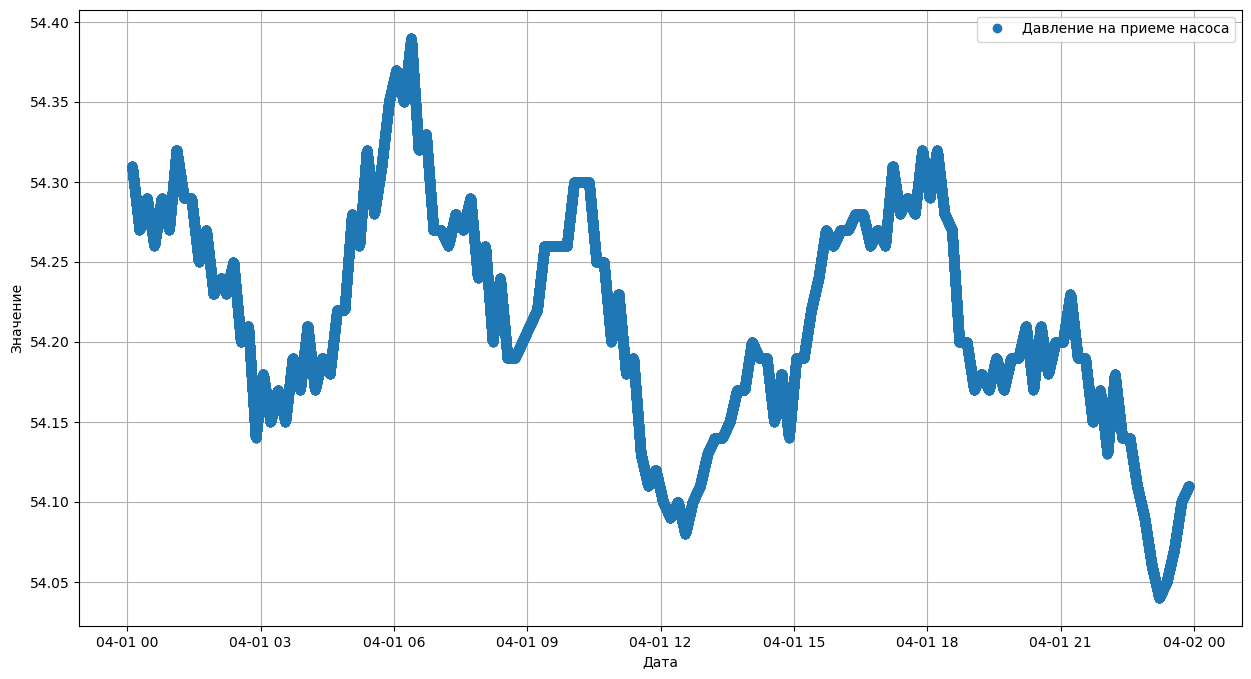

In [119]:
# Построение графика
plt.figure(figsize=(15, 8))
plt.plot(df, 'o', label='Давление на приеме насоса')


# Настройки графика

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.xticks() 
plt.yticks() 
plt.grid(True)

# Показ графика
plt.show()

In [121]:
x = df.index.values
y = df['188_Value'].values

### Расчетные функции

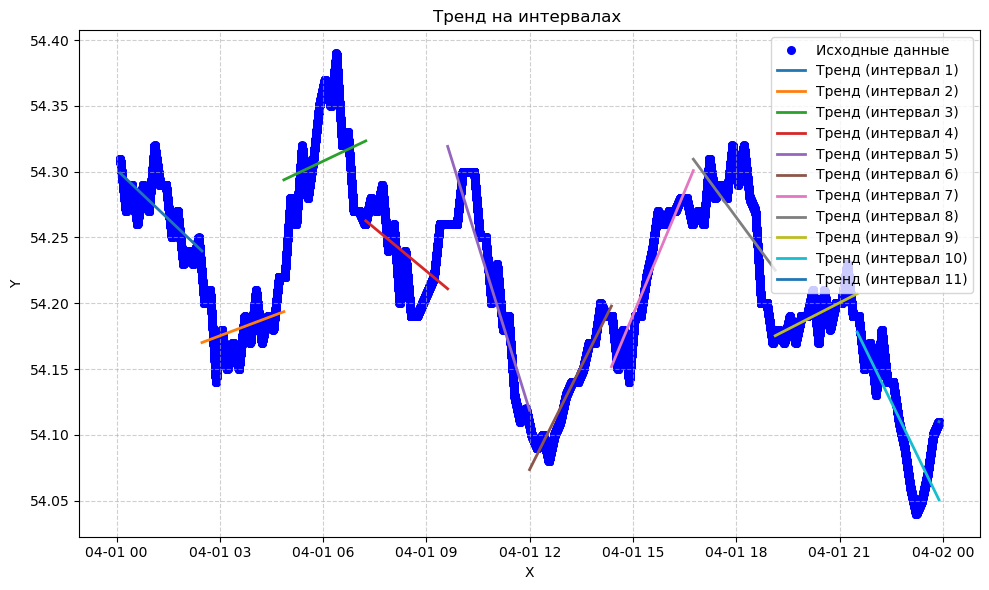

In [124]:
from trend_calculations import calculate_from_zero_to_point_paket, calculate_interval_paket
from drawning import draw_calculations
#array_dfs = calculate_from_zero_to_point_paket(x, y, interval = len(x)//10, method='Bspline')
array_dfs = calculate_interval_paket(x, y, interval = len(x)//10, method= 'linreg')
draw_calculations(x, y, array_dfs, method = 'mat')


In [100]:
len(array_dfs)

11

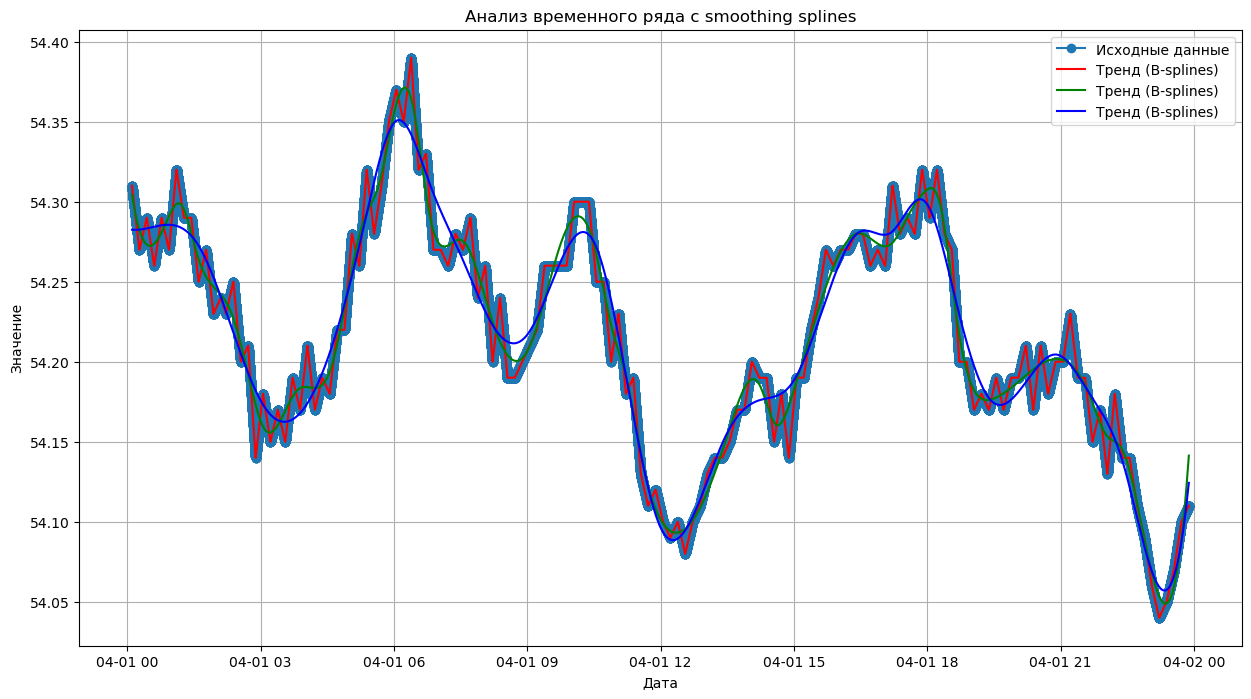

In [250]:

# Графическое отображение данных и тренда
plt.figure(figsize=(15, 8))
plt.plot(df, marker='o', label='Исходные данные')
plt.plot(three_trends['date'], three_trends['trend_0'], color='r', label='Тренд (B-splines)')
plt.plot(three_trends['date'], three_trends['trend_9'], color='g', label='Тренд (B-splines)')
plt.plot(three_trends['date'], three_trends['trend_18'], color='b', label='Тренд (B-splines)')
plt.title('Анализ временного ряда с smoothing splines')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()